<a href="https://colab.research.google.com/github/lapidesd/CA_missing_freshet/blob/main/Colab_notebooks/Interannual_snowmelt_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# no longer being used--doesn't include winter rain
def run_winterET(Smax,PET,PETw,mu,sd,Tmax,spinup,stress=True):
  k = mu**2/sd**2
  theta = sd**2/mu
  P = np.random.gamma(k,theta,Tmax)
  # PETw = 0

  # start of water year, Oct 1
  Soct1 = [0]

  # end of wet season, into dry season
  Sapr1 = []

  # fluxes
  ET = []
  ETspring = []
  Q = []

  for i,p in enumerate(P):
    # wet season ET -- ET is depressed if storage small
    # and can't ET more than is stored
    if stress:
      et0 = np.min([PETw*Soct1[-1]/Smax, Soct1[-1]])
    else:
      et0 = np.min([PETw, Soct1[-1] + p])


    # end of wet season
    sapr1 = np.min([Soct1[-1] + p - et0, Smax])

    # total runoff generated
    q = np.max([Soct1[-1] + p - Smax - et0,0])
    Q.append(q)

    # dry season ET -- ET is depressed if storage small
    # and can't ET more than is stored
    if stress:
      et = np.min([PET*sapr1/Smax, sapr1])
    else:
      et = np.min([PET, sapr1])
    
    # end of dry season (new start of WY)
    soct1 = sapr1 - et

    ET.append(et+et0)
    ETspring.append(et0)
    Sapr1.append(sapr1)
    Soct1.append(soct1)

  Soct1 = np.array(Soct1[spinup:-1])
  ET = np.array(ET[spinup:])
  ETspring = np.array(ETspring[spinup:])
  Q = np.array(Q[spinup:])
  Sapr1 = np.array(Sapr1[spinup:])
  P = P[spinup:]
  years = np.arange(1,len(P)+1)

  Dapr1 = Smax - np.array(Sapr1) 
  Doct1 = Smax - np.array(Soct1)
  return Sapr1, Soct1, P, ET, ETspring, Q, Dapr1, Doct1, years


In [ ]:
# define function to model spring streamflow from SWE

def run_winterET_withP(Smax,PET,PETw,mu,sd,Tmax,spinup,snowfrac,m,stress=True):
  k = mu**2/sd**2
  theta = sd**2/mu
  P = np.random.gamma(k,theta,Tmax)
  # PETw = 0

  # start of water year, Oct 1
  Soct1 = [0]

  # end of wet season, into melt season
  Sapr1 = []

  # end of melt season, into dry season
  Ssummer = []

  # fluxes
  ET = []
  ETspring = []
  Q = []
  Q1 = []

  for i,p in enumerate(P):
    # wet season ET -- ET is depressed if storage small
    # and can't ET more than is stored
    if stress:
      et0 = np.min([PETw*Soct1[-1]/Smax, Soct1[-1]])
    else:
      et0 = np.min([PETw, Soct1[-1] + p])


    # end of wet season
    sapr1 = np.min([Soct1[-1] + p*(1-snowfrac) - et0, Smax])

    # winter runoff generated
    q = np.max([Soct1[-1] + p*(1-snowfrac) - Smax - et0,0])
    Q.append(q)

    # melt season ET -- ET is depressed if storage small
    # and can't ET more than is stored

    meltfrac = (p*snowfrac/m)/180 # assuming a 180-day warm season

    if stress:
      et1 = np.min([PET*meltfrac*sapr1/Smax, sapr1])
    else:
      et1 = np.min([PET*meltfrac, sapr1])

    # snowmelt runoff generated
    q1 = np.max([sapr1 + p*snowfrac - Smax - et1,0])
    Q1.append(q1) 

    # end of melt season
    ssummer = np.min([sapr1 + p*snowfrac - et1,Smax])

    # dry season ET -- ET is depressed if storage small
    # and can't ET more than is stored
    if stress:
      et = np.min([PET*(1-meltfrac)*sapr1/Smax, sapr1])
    else:
      et = np.min([PET*(1-meltfrac), sapr1])
    
    # end of dry season (new start of WY)
    soct1 = ssummer - et

    ET.append(et+et0+et1)
    ETspring.append(et1)
    Sapr1.append(sapr1)
    Soct1.append(soct1)
    Ssummer.append(ssummer)

  Soct1 = np.array(Soct1[spinup:-1])
  ET = np.array(ET[spinup:])
  ETspring = np.array(ETspring[spinup:])
  Q = np.array(Q[spinup:])
  Q1 = np.array(Q1[spinup:])
  Sapr1 = np.array(Sapr1[spinup:])
  P = P[spinup:]
  years = np.arange(1,len(P)+1)

  Dapr1 = Smax - np.array(Sapr1) 
  Doct1 = Smax - np.array(Soct1)
  return Sapr1, Soct1, P, ET, ETspring, Q, Q1, Dapr1, Doct1, years


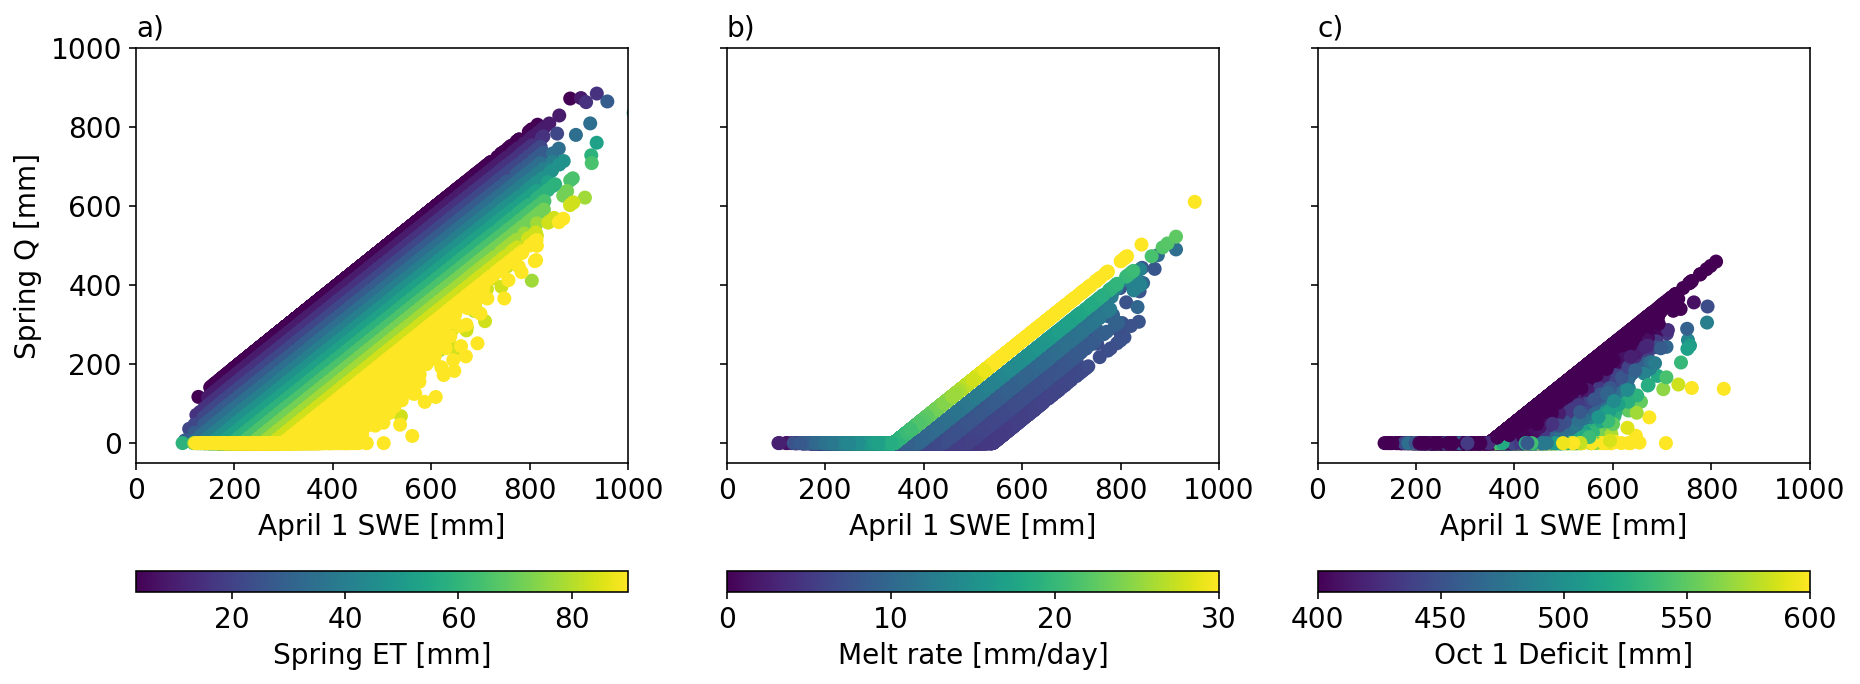

In [ ]:
# this one plots variability based on the model without winter rain

plt.rcParams.update({'font.size': 14})
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
f,axs = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

cmap = matplotlib.cm.get_cmap('viridis')

Smax = 1000
PET = 350
PETw = 0
mu = 400
sd = 100
Tmax = 10000
spinup = 100
Sapr1, Soct1, P, ET,ETspring, Q, Dapr1, Doct1, years = run_winterET(Smax,PET,PETw,mu,sd,Tmax,spinup,stress=False)

ax = axs[2]
c = (Doct1-min(Doct1))/(max(Doct1)-min(Doct1))
c = np.where(np.isfinite(c),c,0)
c = [cmap(c1) for c1 in c]
mappable = ax.scatter(P,Q,c=Doct1,cmap=cmap,vmin=400,vmax=600)
ax.set_xlabel('April 1 SWE [mm]')


divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75)
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Oct 1 Deficit [mm]')

ax = axs[0]
Pall = []
PETall = []
ETspringall = []
Qall = []
for PET in np.linspace(10,300,15):
  c = cmap((PET-10)/900)
  Smax = 1000
  mu = 400
  sd = 100
  PETw = 0.3*PET
  PET = 0.7*PET
  Tmax = 10000
  spinup = 100
  Sapr1, Soct1, P, ET, ETspring, Q, Dapr1, Doct1, years = run_winterET(Smax,PET,PETw,mu,sd,Tmax,spinup,stress=False)
  Pall = Pall + list(P)
  PETall = PETall + list(ET)
  ETspringall = ETspringall + list(ETspring)
  Qall = Qall + list(Q)

mappable = ax.scatter(Pall,Qall,c=ETspringall,cmap=cmap)
ax.set_xlabel('April 1 SWE [mm]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75)
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Spring ET [mm]')


ax = axs[1]
Qall = []
Pall = []
ETall = []
PETwall = []
for PETw in np.linspace(0.6,0.1,5):
  c = cmap(PETw)
  PETwall = PETwall + [PETw]*len(P)
  Smax = 300
  mu = 400
  sd = 100
  PET = 400*(1-PETw)
  PETw = 400*PETw
  Tmax = 10000
  spinup = 100
  Sapr1, Soct1, P, ET, ETspring, Q, Dapr1, Doct1, years = run_winterET(Smax,PET,PETw,mu,sd,Tmax,spinup,stress=False)
  Pall = Pall + list(P)
  ETall = ETall + list(ET)
  Qall = Qall + list(Q)

meltrate = np.array(Pall)/np.array(PETwall)/180
mappable = ax.scatter(Pall,Qall,c=meltrate,cmap=cmap,
                      vmin = 0, vmax = 30)
ax.set_xlabel('April 1 SWE [mm]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75, )
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Melt rate [mm/day]')

ax.set_xlim(0,1000)
ax.set_ylim(-50,1000)


axs[0].text(0,1030,'a)')
axs[0].set_ylabel('Spring Q [mm]')
axs[1].text(0,1030,'b)')
axs[2].text(0,1030,'c)')

plt.savefig('hypotheses_model.png',format='png',bbox_inches = 'tight',
            dpi=300)

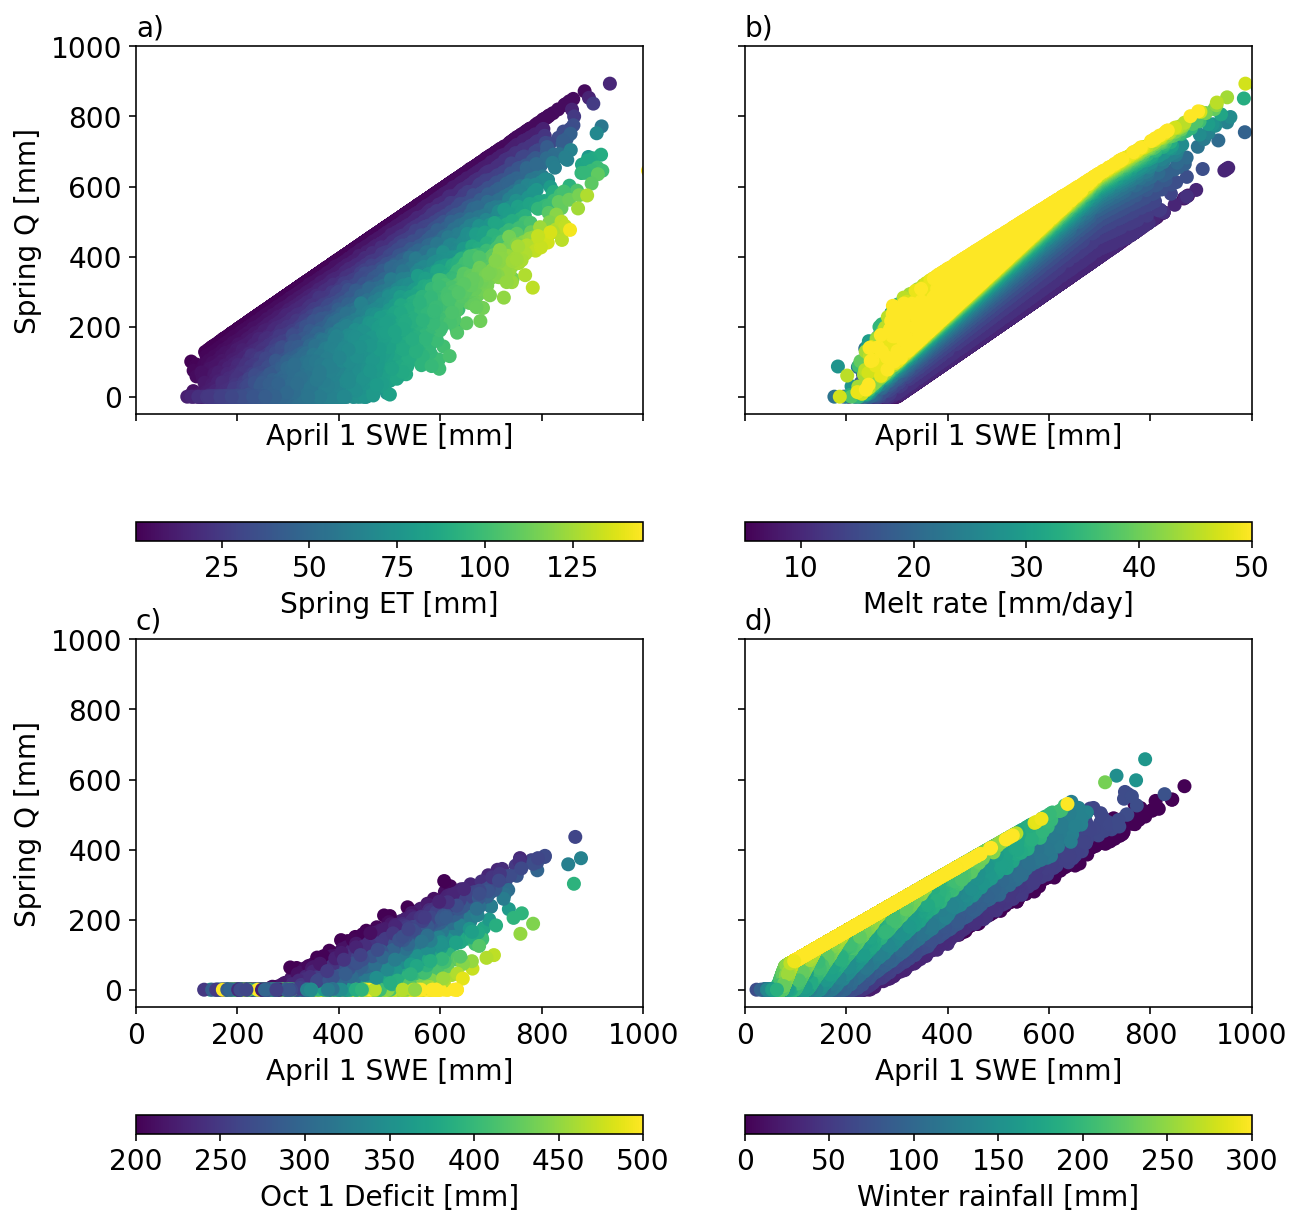

In [ ]:
# plot impact of each parameter on outcomes using the model including winter rain

plt.rcParams.update({'font.size': 14})
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
f,axs = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

cmap = matplotlib.cm.get_cmap('viridis')

Smax = 1000
PET = 350
PETw = 0
mu = 400
sd = 100
Tmax = 10000
spinup = 100
snowfrac = 1
m = 10
Sapr1, Soct1, P, ET,ETspring, Q, Q1, Dapr1, Doct1, years = run_winterET_withP(Smax,PET,PETw,mu,sd,Tmax,spinup,snowfrac,m,stress=False)

ax = axs[1,0]
c = (Doct1-min(Doct1))/(max(Doct1)-min(Doct1))
c = np.where(np.isfinite(c),c,0)
c = [cmap(c1) for c1 in c]
mappable = ax.scatter(P,Q1,c=Doct1,cmap=cmap,vmin=200,vmax=500)
ax.set_xlabel('April 1 SWE [mm]')


divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75)
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Oct 1 Deficit [mm]')

ax = axs[0,0]
Pall = []
PETall = []
ETspringall = []
Qall = []
for PET in np.linspace(10,300,15):
  c = cmap((PET-10)/900)
  Smax = 1000
  mu = 400
  sd = 100
  PETw = 0
  Tmax = 10000
  spinup = 100
  snowfrac = 1
  m = 10
  Sapr1, Soct1, P, ET, ETspring, Q, Q1, Dapr1, Doct1, years = run_winterET_withP(Smax,PET,PETw,mu,sd,Tmax,spinup,snowfrac, m, stress=False)
  Pall = Pall + list(P)
  PETall = PETall + list(ET)
  ETspringall = ETspringall + list(ETspring)
  Qall = Qall + list(Q1)

mappable = ax.scatter(Pall,Qall,c=ETspringall,cmap=cmap)
ax.set_xlabel('April 1 SWE [mm]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75)
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Spring ET [mm]')


ax = axs[0,1]
Qall = []
Pall = []
ETall = []
PETwall = []
mm = []
for m in np.linspace(5,50,30):
  c = cmap(PETw)
  Smax = 300
  mu = 700
  sd = 150
  PET = 800
  PETw = 0
  Tmax = 1000
  spinup = 100
  snowfrac = 0.7
  Sapr1, Soct1, P, ET, ETspring, Q, Q1, Dapr1, Doct1, years = run_winterET_withP(Smax,PET,PETw,mu,sd,Tmax,spinup,snowfrac,m,stress=False)
  Pall = Pall + list(P*snowfrac)
  ETall = ETall + list(ET)
  Qall = Qall + list(Q1)
  mm = mm + [m]*len(Q)

meltrate = mm
mappable = ax.scatter(Pall,Qall,c=meltrate,cmap=cmap,
                      vmin = 5, vmax = 50)
ax.set_xlabel('April 1 SWE [mm]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75, )
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Melt rate [mm/day]')

ax = axs[1,1]
Qall = []
Pall = []
ETall = []
PETwall = []
sfrac = []
for snowfrac in np.linspace(0,.75,10):
  snowfrac = 1-snowfrac
  c = cmap(PETw)
  Smax = 300
  mu = 400
  sd = 100
  PET = 300
  PETw = 0
  Tmax = 10000
  spinup = 100
  m = 10
  Sapr1, Soct1, P, ET, ETspring, Q, Q1, Dapr1, Doct1, years = run_winterET_withP(Smax,PET,PETw,mu,sd,Tmax,spinup,snowfrac,m,stress=False)
  Pall = Pall + list(P)
  ETall = ETall + list(ET)
  Qall = Qall + list(Q1)
  sfrac = sfrac + [snowfrac]*len(Q)


mappable = ax.scatter(np.array(Pall)*np.array(sfrac),Qall,c=(1-np.array(sfrac))*np.array(Pall),cmap=cmap,
                      vmin = 0., vmax = 300)
ax.set_xlabel('April 1 SWE [mm]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.75, )
cb = f.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label('Winter rainfall [mm]')

ax.set_xlim(0,1000)
ax.set_ylim(-50,1000)


axs[0,0].text(0,1030,'a)')
axs[0,0].set_ylabel('Spring Q [mm]')
axs[1,0].set_ylabel('Spring Q [mm]')
axs[0,1].text(0,1030,'b)')
axs[1,0].text(0,1030,'c)')
axs[1,1].text(0,1030,'d)')

plt.savefig('hypotheses_model_withrain.png',format='png',bbox_inches = 'tight',
            dpi=300)